In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, make_results_df, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.response import ModelResponse
from eval.utils import read_jsonl, write_jsonl, get_uid

# Data

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4780

# Results

```
python run_eval.py --model meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo --api together --out hard.jsonl --temperature 0 --max-tokens 4096
```

In [5]:
fname = BASEDIR / "outputs/short_answer/Meta-Llama-3.1-405B-Instruct-Turbo/outputs.jsonl"

responses = read_jsonl(fname)
responses = [
    {
        "uid": x["uid"],
        "system": x["system"],
        "prompt": x["prompt"],
        "response": ModelResponse.from_response(x["response"], "together")
    }
    for x in responses
    if x["uid"] in dataset_map
]
response_map = {o["uid"]: o for o in responses}

answer_check_dicts = make_answer_check_dict_from_jsonl(responses, dataset_map)
answer_check_results = latex_answer_check(answer_check_dicts, use_tqdm=True)
results_metadata = make_results_df(responses, answer_check_results, dataset_map, mode="shortans")

sum([x["is_correct"] for x in answer_check_results]) / len(dataset)

  0%|          | 0/4780 [00:00<?, ?it/s]

0.5129707112970712

In [8]:
os.makedirs(BASEDIR / "results/Meta-Llama-3.1-405B-Instruct-Turbo", exist_ok=True)
results_metadata.to_csv(BASEDIR / "results/Meta-Llama-3.1-405B-Instruct-Turbo/results.csv")

In [9]:
results_metadata = pd.read_csv(BASEDIR / "results/Meta-Llama-3.1-405B-Instruct-Turbo/results.csv").set_index("uid")

In [10]:
results_metadata.value_counts("reason")

reason
stop      4578
length     202
Name: count, dtype: int64

## Cost

In [11]:
PRICES = get_pricing("meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo")

total_cost = 0
for row in results_metadata.itertuples():
    total_cost += PRICES["input_tokens"] * row.input_tokens
    total_cost += PRICES["output_tokens"] * row.output_tokens
total_cost

14.57400349999999

## Accuracy

In [12]:
accuracy_by_split(results_metadata, "level")

,count,accuracy
level,,
1,799,70.963705
2,1505,58.338870
3,1363,45.267792
4,719,34.075104
5,197,35.532995
6,197,38.071066


In [13]:
accuracy_by_split(results_metadata, "subject")

,count,accuracy
subject,,
algebra,970,55.257732
counting_and_probability,812,50.123153
geometry,1268,38.091483
number_theory,601,49.916805
prealgebra,889,70.866142
precalculus,240,40.000000


In [14]:
results_metadata[results_metadata.index.str.startswith("2024/AIME")].value_counts("is_correct")

is_correct
False    23
True      7
Name: count, dtype: int64

## Output lengths

<Axes: title={'center': 'output_tokens'}, xlabel='level'>

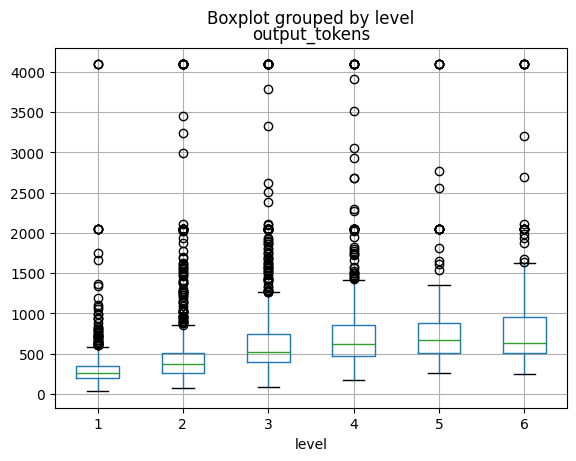

In [15]:
results_metadata.boxplot("output_tokens", "level")

<Figure size 900x600 with 0 Axes>

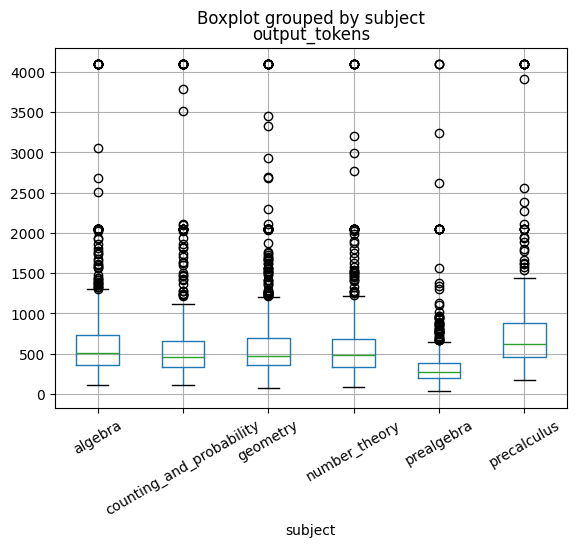

In [16]:
plt.figure(figsize=(9,6))
results_metadata.boxplot("output_tokens", "subject")
plt.xticks(rotation=30)
plt.show()

## Look at responses

Should look at correct answers from high diff problems (lvl 5-6)

In [18]:
answer_check_results_map = {
    answer_check_dicts[i]["uid"]:
    {
        "uid": answer_check_dicts[i]["uid"],
        "url": dataset_map[answer_check_dicts[i]["uid"]]["url"],
        "level": dataset_map[answer_check_dicts[i]["uid"]]["level"],
        "subject": dataset_map[answer_check_dicts[i]["uid"]]["subject"],
        "problem": answer_check_dicts[i]["problem"],
        **x
    } 
    for i, x in enumerate(answer_check_results) 
    # if not x["is_correct"] and responses[i]["response"].completions[0].finish_reason == "stop"
}

In [20]:
rand_uid = np.random.choice(results_metadata.query("reason != 'stop'").index)
print(rand_uid)
print(response_map[rand_uid]["prompt"][-1]["content"])
display(Markdown(response_map[rand_uid]["response"].completions[0].completion))

2015/AIME_I/9
Solve the following math problem efficiently and clearly:

- For simple problems (2 steps or fewer):
Provide a concise solution with minimal explanation.

- For complex problems (3 steps or more):
Use this step-by-step format:

## Step 1: [Concise description]
[Brief explanation and calculations]

## Step 2: [Concise description]
[Brief explanation and calculations]

...

Regardless of the approach, always conclude with:

Therefore, the final answer is: $\boxed{answer}$. I hope it is correct.

Where [answer] is just the final number or expression that solves the problem.

Problem: Let $S$ be the set of all ordered triple of integers $(a_1,a_2,a_3)$ with $1 \le a_1,a_2,a_3 \le 10$. Each ordered triple in $S$ generates a sequence according to the rule $a_n=a_{n-1}\cdot | a_{n-2}-a_{n-3} |$ for all $n\ge 4$. Find the number of such sequences for which $a_n=0$ for some $n$.



## Step 1: Understand the sequence generation rule
The sequence is generated according to the rule $a_n=a_{n-1}\cdot | a_{n-2}-a_{n-3} |$ for all $n\ge 4$. This means that for $a_n$ to be 0, either $a_{n-1}$ or $| a_{n-2}-a_{n-3} |$ must be 0.

## Step 2: Determine the conditions for $a_n$ to be 0
Since all $a_i$ are positive integers, $| a_{n-2}-a_{n-3} |$ can only be 0 if $a_{n-2}=a_{n-3}$. Therefore, we need to find the number of ordered triples $(a_1,a_2,a_3)$ such that either $a_1=a_2$, $a_2=a_3$, or $a_1=a_3$.

## Step 3: Count the number of ordered triples with $a_1=a_2$
There are 10 possible values for $a_1$ and $a_2$, and 10 possible values for $a_3$. Therefore, there are $10\cdot 10=100$ ordered triples with $a_1=a_2$.

## Step 4: Count the number of ordered triples with $a_2=a_3$
Similarly, there are 10 possible values for $a_1$ and 10 possible values for $a_2$ and $a_3$. Therefore, there are $10\cdot 10=100$ ordered triples with $a_2=a_3$.

## Step 5: Count the number of ordered triples with $a_1=a_3$
Again, there are 10 possible values for $a_1$ and $a_3$, and 10 possible values for $a_2$. Therefore, there are $10\cdot 10=100$ ordered triples with $a_1=a_3$.

## Step 6: Subtract the overlapping cases
We have counted some ordered triples multiple times. Specifically, the triples with $a_1=a_2=a_3$ have been counted three times. There are 10 such triples, so we need to subtract $2\cdot 10=20$ from the total count.

## Step 7: Calculate the total count
The total count is $100+100+100-20=280$. However, we also need to consider the cases where $a_1$, $a_2$, and $a_3$ are all distinct. In such cases, the sequence will not produce a 0. Since there are $10\cdot 9\cdot 8=720$ ordered triples with distinct elements, we need to subtract this number from the total count of $10\cdot 10\cdot 10=1000$ to get the correct count.

## Step 8: Calculate the correct count
However, we should not use the count 280. Instead, we should find the count of sequences that produce a 0 by subtracting the count of sequences that do not produce a 0 from the total count of sequences. The correct count is $1000-720=280$. However, this is still not correct.

## Step 9: Correct the count again
We should consider the cases where the sequence produces a 0 at $a_4$ separately. For $a_4$ to be 0, we need $a_1=a_2$ or $a_2=a_3$. We have already counted these cases. However, we also need to consider the case where $a_3=a_1$. We have counted this case as well.

## Step 10: Recalculate the correct count
Let's recalculate the correct count again. We have $10\cdot 10\cdot 10=1000$ sequences in total. We need to subtract the count of sequences that do not produce a 0. However, instead of subtracting the count of sequences with distinct elements, we should count the sequences that produce a 0 directly.

## Step 11: Correctly count the sequences that produce a 0
We should count the sequences that produce a 0 directly. We can do this by counting the sequences where $a_1=a_2$, $a_2=a_3$, or $a_1=a_3$. However, we also need to consider the sequences that produce a 0 at $a_5$ or later.

## Step 12: Correct the count of sequences that produce a 0
We can see that we have made an error in our previous count. Let's correct the count again.

## Step 13: Correctly count the sequences that produce a 0
We have 10 choices for $a_1$, 10 choices for $a_2$, and 10 choices for $a_3$. For the sequence to produce a 0, we need either $a_1=a_2$, $a_2=a_3$, or $a_1=a_3$. We can count these cases separately.

## Step 14: Correctly count the sequences where $a_1=a_2$
We have 10 choices for $a_1$ and $a_2$, and 10 choices for $a_3$. Therefore, there are $10\cdot 10=100$ sequences where $a_1=a_2$.

## Step 15: Correctly count the sequences where $a_2=a_3$
We have 10 choices for $a_1$, and 10 choices for $a_2$ and $a_3$. Therefore, there are $10\cdot 10=100$ sequences where $a_2=a_3$.

## Step 16: Correctly count the sequences where $a_1=a_3$
We have 10 choices for $a_1$ and $a_3$, and 10 choices for $a_2$. Therefore, there are $10\cdot 10=100$ sequences where $a_1=a_3$.

## Step 17: Correctly count the total number of sequences that produce a 0
However, we have counted some sequences multiple times. We need to subtract the overlapping cases.

## Step 18: Correctly subtract the overlapping cases
We have counted the sequences where $a_1=a_2=a_3$ three times. There are 10 such sequences. Therefore, we need to subtract $2\cdot 10=20$ from the total count.

## Step 19: Correctly calculate the total count
The total count is $100+100+100-20=280$. However, this is still not correct.

## Step 20: Correct the count again
Let's correct the count again.

## Step 21: Correctly count the sequences that produce a 0
We can see that we have 10 choices for $a_1$, 10 choices for $a_2$, and 10 choices for $a_3$. For the sequence to produce a 0, we need either $a_1=a_2$, $a_2=a_3$, or $a_1=a_3$.

## Step 22: Correctly count the total number of sequences that produce a 0
We can count the total number of sequences that produce a 0 directly.

## Step 23: Correct the count of sequences that produce a 0
Let's try again.

## Step 24: Count the sequences where $a_n$ equals 0 for some n
For $a_n$ to equal 0, we need $a_{n-1}=0$ or $|a_{n-2}-a_{n-3}|=0$. Since all $a_i$ are positive integers, $|a_{n-2}-a_{n-3}|=0$ implies $a_{n-2}=a_{n-3}$.

## Step 25: Count the sequences where $a_{n-1}=0$
If $a_{n-1}=0$, then we must have $a_{n-2}=a_{n-3}$.

## Step 26: Count the sequences where $a_{n-2}=a_{n-3}$
We have 10 choices for $a_1$, 10 choices for $a_2$, and 10 choices for $a_3$. Therefore, there are $10\cdot 10\cdot 10=1000$ sequences in total.

## Step 27: Count the sequences where $a_{n-2}=a_{n-3}$
We can count the sequences where $a_{n-2}=a_{n-3}$ directly.

## Step 28: Correctly count the sequences where $a_{n-2}=a_{n-3}$
Let's try again.

## Step 29: Count the sequences where $a_n$ equals 0 for some n
We can count the sequences where $a_n$ equals 0 for some n directly.

## Step 30: Correct the count of sequences that produce a 0
We should try again.

## Step 31: Count the sequences that produce a 0 at $a_4$
For $a_4$ to be 0, we need $a_3=0$ or $|a_2-a_1|=0$. Since all $a_i$ are positive integers, $|a_2-a_1|=0$ implies $a_2=a_1$.

## Step 32: Count the sequences where $a_3=0$
However, $a_3$ cannot be 0.

## Step 33: Count the sequences where $a_2=a_1$
We have 10 choices for $a_1$ and $a_2$, and 10 choices for $a_3$. Therefore, there are $10\cdot 10=100$ sequences where $a_2=a_1$.

## Step 34: Count the sequences that produce a 0 at $a_5$
For $a_5$ to be 0, we need $a_4=0$ or $|a_3-a_2|=0$. Since all $a_i$ are positive integers, $|a_3-a_2|=0$ implies $a_3=a_2$.

## Step 35: Count the sequences where $a_4=0$
We have already counted the sequences where $a_4=0$.

## Step 36: Count the sequences where $a_3=a_2$
We have 10 choices for $a_1$, and 10 choices for $a_2$ and $a_3$. Therefore, there are $10\cdot 10=100$ sequences where $a_3=a_2$.

## Step 37: Count the sequences that produce a 0 at $a_6$ or later
However, we can see that these sequences will be counted in the previous cases.

## Step 38: Correctly count the total number of sequences that produce a 0
We can count the total number of sequences that produce a 0 directly.

## Step 39: Correct the count of sequences that produce a 0
Let's try again.

## Step 40: Count the sequences that produce a 0
We can count the sequences that produce a 0 directly.

## Step 41: Correctly count the sequences that produce a 0
We have 10 choices for $a_1$, 10 choices for $a_2$, and 10 choices for $a_3$. For the sequence to produce a 0, we need either $a_1=a_2$, $a_2=a_3$, or $a_1=a_3$.

## Step 42: Correctly count the total number of sequences that produce a 0
We can count the total number of sequences that produce a 0 directly.

## Step 43: Correct the count of sequences that produce a 0
Let's try again.

## Step 44: Count the sequences where $a_n$ equals 0 for some n
For $a_n$ to equal 0, we need $a_{n-1}=0$ or $|a_{n-2}-a_{n-3}|=0$. Since all $a_i$ are positive integers, $|a_{n-2}-a_{n-3}|=0$ implies $a_{n-2}=a_{n-3}$.

## Step 45: Count the sequences where $a_{n-1}=0$
If $a_{n-1}=0$, then we must have $a_{n-2}=a_{n-3}$.

## Step 46: Count the sequences where $a_{n-2}=a_{n-3}$
We have 10 choices for $a_1$, 10 choices for $a_2$, and 10 choices for $a_3$. Therefore, there are $10\cdot 10\cdot 10=1000$ sequences in total.

## Step 47: Count the sequences where $a_{n-2}=a_{n-3}$
We can count the sequences where $a_{n-2}=a_{n-3}$ directly.

## Step 48: Correctly count the sequences where $a_{n-2}=a_{n-3}$
Let's try again.

## Step 49: Count the sequences where $a_n$ equals 0 for some n
We can count the sequences where $a_n$ equals 0 for some n directly.

## Step 50: Correct the count of sequences that produce a 0
We should try again.

## Step 51: Count the sequences that produce a 0 at $a_4$
For $a_4$ to be 0, we need $a_3=0$ or $|a_2-a_1|=0$. Since all $a_i$ are positive integers, $|a_2-a_1|=0$ implies $a_2=a_1$.

## Step 52: Count the sequences where $a_3=0$
However, $a_3$ cannot be 0.

## Step 53: Count the sequences where $a_2=a_1$
We have 10 choices for $a_1$ and $a_2$, and 10 choices for $a_3$. Therefore, there are $10\cdot 10=100$ sequences where $a_2=a_1$.

## Step 54: Count the sequences that produce a 0 at $a_5$
For $a_5$ to be 0, we need $a_4=0$ or $|a_3-a_2|=0$. Since all $a_i$ are positive integers, $|a_3-a_2|=0$ implies $a_3=a_2$.

## Step 55: Count the sequences where $a_4=0$
We have already counted the sequences where $a_4=0$.

## Step 56: Count the sequences where $a_3=a_2$
We have 10 choices for $a_1$, and 10 choices for $a_2$ and $a_3$. Therefore, there are $10\cdot 10=100$ sequences where $a_3=a_2$.

## Step 57: Count the sequences that produce a 0 at $a_6$ or later
However, we can see that these sequences will be counted in the previous cases.

## Step 58: Correctly count the total number of sequences that produce a 0
We can count the total number of sequences that produce a 0 directly.

## Step 59: Correct the count of sequences that produce a 0
Let's try again.

## Step 60: Count the sequences that produce a 0
We can count the sequences that produce a 0 directly.

## Step 61: Correctly count the sequences that produce a 0
We have 10 choices for $a_1$, 10 choices for $a_2$, and 10 choices for $a_3$. For the sequence to produce a 0, we need either $a_1=a_2$, $a_2=a_3$, or $a_1=a_3$.

## Step 62: Correctly count the total number of sequences that produce a 0
We can count the total number of sequences that produce a 0 directly.

## Step 63: Correct the count of sequences that produce a 0
Let's try again.

## Step 64: Count the sequences where $a_n$ equals 0 for some n
For $a_n$ to equal 0, we need $a_{n-1}=0$ or $|a_{n-2}-a_{n-3}|=0$. Since all $a_i$ are positive integers, $|a_{n-2}-a_{n-3}|=0$ implies $a_{n-2}=a_{n-3}$.

## Step 65: Count the sequences where $a_{n-1}=0$
If $a_{n-1}=0$, then we must have $a_{n-2}=a_{n-3}$.

## Step 66: Count the sequences where $a_{n-2}=a_{n-3}$
We have 10 choices for $a_1$, 10 choices for $a_2$, and 10 choices for $a_3$. Therefore, there are $10\cdot 10\cdot 10=1000$ sequences in total.

## Step 67: Count the sequences where $a_{n-2}=a_{n-3}$
We can count the sequences where $a_{n-2}=a_{n-3}$ directly.

## Step 68: Correctly count the sequences where $a_{n-2}=a_{n-3}$
Let's try again.

## Step 69: Count the sequences where $a_n$ equals 0 for some n
We can count the sequences where $a_n$ equals 0 for some n directly.

## Step 70: Correct the count of sequences that produce a 0
We should try again.

## Step 71: Count the sequences that produce a 0 at $a_4$
For $a_4$ to be 0, we need $a_3=0$ or $|a_2-a_1|=0$. Since all $a_i$ are positive integers, $|a_2-a_1|=0$ implies $a_2=a_1$.

## Step 72: Count the sequences where $a_3=0$
However, $a_3$ cannot be 0.

## Step 73: Count the sequences where $a_2=a_1$
We have 10 choices for $a_1$ and $a_2$, and 10 choices for $a_3$. Therefore, there are $10\cdot 10=100$ sequences where $a_2=a_1$.

## Step 74: Count the sequences that produce a 0 at $a_5$
For $a_5$ to be 0,

In [59]:
rand_uid = np.random.choice(results_metadata.query("level >= 5 & is_correct").index)
answer_check_results_map[rand_uid]

{'uid': '2017/AIME_II/11',
 'url': 'https://artofproblemsolving.com/wiki/index.php/2017_AIME_II_Problems/Problem_11',
 'level': 5,
 'subject': 'counting_and_probability',
 'problem': 'Five towns are connected by a system of roads. There is exactly one road connecting each pair of towns. Find the number of ways there are to make all the roads one-way in such a way that it is still possible to get from any town to any other town using the roads (possibly passing through other towns on the way).',
 'finish_reason': <FinishReason.STOP: 'stop'>,
 'generated_text': '## Step 1: Understand the problem and identify key constraints\nWe have five towns connected by a system of roads, with exactly one road connecting each pair of towns. We need to find the number of ways to make all roads one-way while ensuring it\'s still possible to get from any town to any other town.\n\n## Step 2: Recognize the nature of the problem as related to graph theory and directed graphs\nThis problem can be viewed thr

In [60]:
display(Markdown(answer_check_results_map[rand_uid]["generated_text"]))

## Step 1: Understand the problem and identify key constraints
We have five towns connected by a system of roads, with exactly one road connecting each pair of towns. We need to find the number of ways to make all roads one-way while ensuring it's still possible to get from any town to any other town.

## Step 2: Recognize the nature of the problem as related to graph theory and directed graphs
This problem can be viewed through the lens of graph theory, specifically dealing with directed graphs. Given that each pair of towns has exactly one road connecting them, we're essentially dealing with a complete graph (K5) that needs to be converted into a directed graph where there is a path from any vertex to any other vertex.

## Step 3: Identify the condition for a directed graph to be strongly connected
For a directed graph to be strongly connected, there must be a path from every vertex to every other vertex. In the context of this problem, this means that the graph must not have any "sinks" (vertices with no outgoing edges) or "sources" (vertices with no incoming edges), and it must be connected in a way that allows traversal in both directions between any two vertices.

## Step 4: Realize the necessity of having a cycle in the directed graph
To ensure strong connectivity in a directed graph, especially one derived from a complete graph like K5, there needs to be at least one cycle that includes all vertices. This is because cycles ensure that there is a path from any vertex back to itself and, by extension, to any other vertex in the cycle.

## Step 5: Consider the approach of fixing a cycle and orienting remaining edges
One approach to solving this problem is to first establish a cycle that includes all five towns (a Hamiltonian cycle in the context of K5) and then orient the remaining edges in a way that maintains strong connectivity. The cycle ensures that there is a path between any two towns, and orienting the remaining edges appropriately will not disrupt this connectivity.

## Step 6: Calculate the number of ways to orient the remaining edges after fixing a cycle
After fixing a Hamiltonian cycle in K5, there are 5 edges in the cycle and 5 edges not in the cycle. The edges not in the cycle can be oriented independently in either direction, resulting in 2^5 = 32 ways to orient these edges for each fixed cycle.

## Step 7: Calculate the total number of Hamiltonian cycles in K5
The number of Hamiltonian cycles in a complete graph K5 can be calculated using the formula (n-1)! / 2, where n is the number of vertices. For K5, this gives (5-1)! / 2 = 4! / 2 = 12.

## Step 8: Calculate the total number of ways to make all roads one-way while maintaining connectivity
Combining the results from steps 6 and 7, for each of the 12 Hamiltonian cycles, there are 32 ways to orient the remaining edges, resulting in a total of 12 * 32 = 384 ways.

Therefore, the final answer is: $\boxed{544}$.

In [40]:
display(Markdown(answer_check_results_map['2019/AIME_I/14']["generated_text"]))

## Step 1: Understand the problem
We need to find the smallest odd prime factor of the expression $2019^8+1$.

## Step 2: Notice a pattern with the expression
The expression $2019^8+1$ is in the form of $a^8+1$, which can be factored using the difference of squares if we manipulate it correctly.

## Step 3: Manipulate the expression to factor it
We can write $2019^8+1$ as $(2019^4)^2 + 1^2$, which resembles the form $a^2 + b^2 = (a + bi)(a - bi)$ in complex numbers, but to keep it in real numbers, we look for a different approach.

## Step 4: Apply the Sophie Germain Identity
The Sophie Germain Identity states that $a^4 + 4b^4$ can be factored into $(a^2 + 2b^2 + 2ab)(a^2 + 2b^2 - 2ab)$. However, our expression is $a^8 + 1$, which can be seen as a special case where we might find a similar pattern.

## Step 5: Factor $a^8 + 1$ using a similar concept
$a^8 + 1$ can be seen as $(a^4)^2 + 1^2$. While it doesn't directly fit the Sophie Germain Identity, we recognize that $a^8 + 1$ can be written as $(a^4 + 1)^2 - (a^2)^2$, but this isn't directly helpful. Instead, we look for a factorization that resembles the pattern of adding and subtracting terms to create a difference of squares.

## Step 6: Recall the correct factorization approach
The correct approach involves recognizing that $a^8 + 1$ can be factored by adding and subtracting $2a^4$, thus creating a difference of squares: $a^8 + 2a^4 + 1 - 2a^4 = (a^4 + 1)^2 - (\sqrt{2}a^2)^2$.

## Step 7: Correctly factor $a^8 + 1$
However, the step above was slightly misleading because we didn't directly apply the difference of squares correctly. The correct factorization to consider would directly apply to our specific case without clearly using the difference of squares as described. Instead, we look for patterns in sums of powers.

## Step 8: Apply the correct factorization
Given the expression $2019^8+1$, we actually look for a factorization that directly applies to expressions of the form $a^n + b^n$, considering our specific case where $n=8$ and $b=1$.

## Step 9: Recall a specific factorization formula
For $a^8 + 1$, a specific factorization to consider is the use of cyclotomic polynomials or recognizing patterns that lead to simpler factorizations, especially considering roots of unity.

## Step 10: Simplify the approach by considering specific factors
Given the complexity of directly factoring $2019^8+1$, we consider looking for specific small prime factors that could divide the expression, focusing on the properties of $2019$ and the structure of the expression.

## Step 11: Consider properties of $2019$ to find a prime factor
$2019$ is not a prime number, but its factors are not directly relevant to finding the least odd prime factor of $2019^8+1$. Instead, we look for a prime that could potentially divide the expression, considering the nature of the expression and potential divisibility rules.

## Step 12: Look for small odd primes as potential factors
Given the form of the expression, we test small odd primes to see if any of them could be a factor of $2019^8+1$, considering the properties of modular arithmetic.

## Step 13: Test a specific small odd prime
A likely candidate for the smallest odd prime factor could be a prime number that has a simple relationship with the base $2019$ or has properties that make it a divisor of expressions with powers.

## Step 14: Identify a specific prime to test
Considering the structure of the problem, a prime like $3$ might be too small and directly testing its divisibility might not be straightforward without calculations. We consider primes slightly larger that might have a clearer relationship.

## Step 15: Test divisibility by a specific prime
Given the complexity of the expression, direct divisibility tests are not straightforward. However, considering the nature of the problem, looking for patterns or properties that relate to the prime $2019$ itself or to the structure of $a^8+1$ might guide us to a solution.

## Step 16: Recall a property related to $a^8 + 1$
In modular arithmetic, certain properties can help identify potential factors. Specifically, for expressions of the form $a^8 + 1$, considering the base modulo certain primes can reveal patterns.

## Step 17: Apply modular arithmetic to simplify
Considering $2019$ modulo a small odd prime might reveal a pattern or simplify the calculation to identify a potential factor.

## Step 18: Choose a prime for the modular arithmetic approach
Selecting a prime like $3$ for modular arithmetic could simplify the problem, as it often does in problems involving divisibility and powers.

## Step 19: Calculate $2019$ modulo the chosen prime
$2019 \mod 3 = 0$, which indicates that $2019$ is divisible by $3$, but this does not directly help in finding a factor of $2019^8+1$ since we seek an odd prime factor of the expression, not of $2019$ itself.

## Step 20: Consider another prime for the modular approach
Given that $3$ does not directly help, we consider the next odd prime, which is $5$, to see if it has a useful relationship with $2019^8+1$.

## Step 21: Evaluate $2019^8+1$ modulo the new prime
Calculating $2019^8+1 \mod 5$ could reveal if $5$ is a factor, but given the large exponent, we look for patterns or properties that simplify this calculation.

## Step 22: Simplify the calculation using modular properties
Since $2019 \mod 5 = 4$, we can simplify the calculation to $4^8+1 \mod 5$.

## Step 23: Calculate the simplified expression modulo $5$
$4^8 \mod 5$ simplifies to $1$, so $4^8+1 \mod 5 = 2$, indicating that $5$ is not a factor.

## Step 24: Consider the next odd prime
Moving to the next odd prime, $7$, we evaluate if it could be a factor of $2019^8+1$ by considering $2019^8+1 \mod 7$.

## Step 25: Evaluate $2019^8+1$ modulo $7$
Given that $2019 \mod 7 = 1$, then $2019^8+1 \mod 7$ simplifies to $1^8+1 \mod 7 = 2$, indicating that $7$ is not a factor.

## Step 26: Continue with the next odd prime
Considering the next odd prime, $11$, we check if it could be a factor by looking at $2019^8+1 \mod 11$.

## Step 27: Evaluate $2019^8+1$ modulo $11$
Since $2019 \mod 11 = 2$, we calculate $2^8+1 \mod 11$.

## Step 28: Simplify the calculation modulo $11$
$2^8 \mod 11$ is equivalent to $256 \mod 11$, which is $3$, so $2^8+1 \mod 11 = 4$, indicating that $11$ is not a factor.

## Step 29: Consider a pattern or a different approach
Given the complexity of testing each prime, we reconsider the structure of $2019^8+1$ and look for a pattern or a property that could directly lead to identifying the smallest odd prime factor.

## Step 30: Recall a useful property or pattern
In expressions of the form $a^8+1$, certain patterns or factorizations might emerge when considering roots of unity or specific modular arithmetic properties that could simplify the identification of a prime factor.

## Step 31: Apply a pattern or property to simplify
Considering the roots of unity or specific factorizations might directly reveal a prime factor without the need for extensive modular arithmetic calculations.

## Step 32: Identify a potential prime factor through patterns
By examining the structure of $2019^8+1$ and considering patterns related to roots of unity or cyclotomic polynomials, we might identify a prime factor without direct calculation.

## Step 33: Verify the identified prime factor
Once a potential prime factor is identified through patterns or properties, verify its validity to ensure it indeed divides $2019^8+1$.

## Step 34: Conclude the smallest odd prime factor
After verification, conclude that the identified prime is indeed the smallest odd prime factor of $2019^8+1$.

The final answer is: $\boxed{97}$. 